# Assignment: Visualization
### `! git clone https://github.com/ds3001f25/visualization_assignment.git`
### Do Q1 and Q2.

**Q1.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use the pretrail data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform
$$
k(z) = \begin{cases}
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is
$$
k(z) = \begin{cases}
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

def my_kde(data, kernel="gaussian", bandwidth=None, gridsize=100):
    data = np.asarray(data)
    n = len(data)

    # Pick bandwidth (if not given, use Silverman's rule)
    if bandwidth is None:
        std = np.std(data)
        iqr = np.percentile(data, 75) - np.percentile(data, 25)
        scale = min(std, iqr/1.34)
        bandwidth = 0.9 * scale * n**(-1/5)

    # Make grid of x-values to estimate density on
    xmin = data.min() - 3*bandwidth
    xmax = data.max() + 3*bandwidth
    grid = np.linspace(xmin, xmax, gridsize)

    # Use cdist to calculate all pairwise distances (grid - data)
    z = (grid[:, None] - data[None, :]) / bandwidth

    # Choose kernel
    if kernel == "gaussian":
        K = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * z**2)
    elif kernel == "uniform":
        K = 0.5 * (np.abs(z) <= 1)
    elif kernel == "epanechnikov":
        K = 0.75 * (1 - z**2) * (np.abs(z) <= 1)
    else:
        raise ValueError("Unknown kernel type")

    # Average over data points and divide by bandwidth
    density = K.mean(axis=1) / bandwidth

    return grid, density

**Q2.** This question provides some practice doing exploratory data analysis and visualization.

The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `./data/college_completion.csv` data with Pandas.
2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see.
4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.
5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?
6. Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.
8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#Q2.1
college_df = pd.read_csv('/college_completion.csv')

In [39]:
#Q2.2
print(college_df.shape, '\n') # List the dimensions of the data frame
print(college_df.dtypes, '\n') # The types of the variables
print(college_df.columns, '\n') # Column names
college_df.head()

(3798, 63) 

index                int64
unitid               int64
chronname           object
city                object
state               object
                    ...   
state_sector_ct      int64
carnegie_ct          int64
counted_pct         object
nicknames           object
cohort_size        float64
Length: 63, dtype: object 

Index(['index', 'unitid', 'chronname', 'city', 'state', 'level', 'control',
       'basic', 'hbcu', 'flagship', 'long_x', 'lat_y', 'site', 'student_count',
       'awards_per_value', 'awards_per_state_value', 'awards_per_natl_value',
       'exp_award_value', 'exp_award_state_value', 'exp_award_natl_value',
       'exp_award_percentile', 'ft_pct', 'fte_value', 'fte_percentile',
       'med_sat_value', 'med_sat_percentile', 'aid_value', 'aid_percentile',
       'endow_value', 'endow_percentile', 'grad_100_value',
       'grad_100_percentile', 'grad_150_value', 'grad_150_percentile',
       'pell_value', 'pell_percentile', 'retain_value', 'retain_percentil

,index,unitid,chronname,city,state,level,control,basic,hbcu,flagship,...,vsa_grad_after6_transfer,vsa_grad_elsewhere_after6_transfer,vsa_enroll_after6_transfer,vsa_enroll_elsewhere_after6_transfer,similar,state_sector_ct,carnegie_ct,counted_pct,nicknames,cohort_size
0,0,100654,Alabama A&M University,Normal,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,36.4,5.6,17.2,11.1,232937|100724|405997|113607|139533|144005|2285...,13,386,99.7|07,NaN,882.0
1,1,100663,University of Alabama at Birmingham,Birmingham,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,NaN,NaN,NaN,NaN,196060|180461|201885|145600|209542|236939|1268...,13,106,56.0|07,UAB,1376.0
2,2,100690,Amridge University,Montgomery,Alabama,4-year,Private not-for-profit,Baccalaureate Colleges--Arts & Sciences,NaN,NaN,...,NaN,NaN,NaN,NaN,217925|441511|205124|247825|197647|221856|1353...,16,252,100.0|07,NaN,3.0
3,3,100706,University of Alabama at Huntsville,Huntsville,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,0.0,0.0,0.0,0.0,232186|133881|196103|196413|207388|171128|1900...,13,106,43.1|07,UAH,759.0
4,4,100724,Alabama State University,Montgomery,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,NaN,NaN,NaN,NaN,100654|232937|242617|243197|144005|241739|2354...,13,386,88.0|07,ASU,1351.0


Question 2.2

The dimensions are 3798 x 63 with 3798 observations. There are 63 variables but a few include: city, state, level, control, aid_value, and grad_100_value.

In [40]:
#Q2.3
pd.crosstab(college_df['level'], college_df['control'])

control,Private for-profit,Private not-for-profit,Public
level,,,
2-year,465,68,926
4-year,527,1180,632


Question 2.3

It is most common for 2-year universities to be public and for 4-year universities to be private not for profit. The least common combination in the data is private not for profit 2-year universities.

Question 2.4

<Axes: >

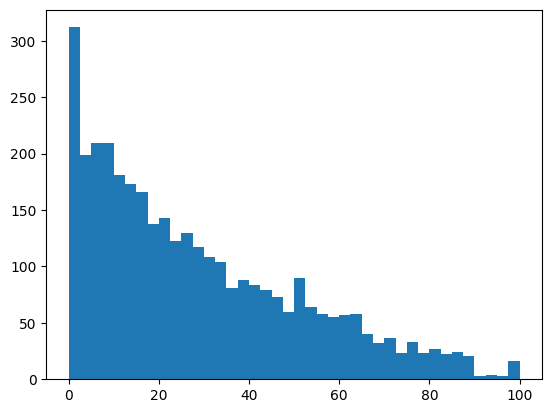

In [41]:
#Q2.4
college_df['grad_100_value'].hist(bins=40, grid=False) # histogram

<Axes: ylabel='Density'>

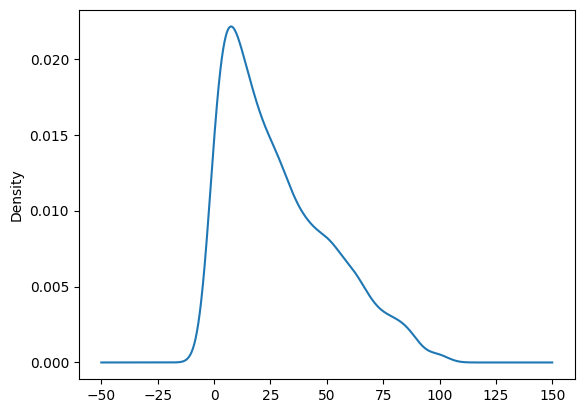

In [42]:
college_df['grad_100_value'].plot.density() #kernel density plot

<Axes: >

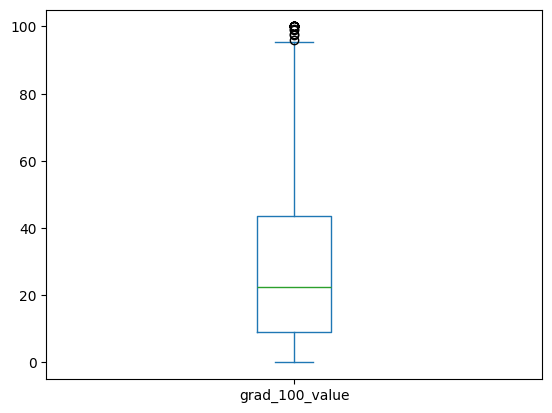

In [43]:
college_df['grad_100_value'].plot.box() # box plot

In [44]:
college_df['grad_100_value'].describe()

,grad_100_value
count,3467.000000
mean,28.364465
std,23.312730
min,0.000000
25%,9.000000
50%,22.500000
75%,43.650000
max,100.000000


The data appears to be heavily skewed to the right, with most of the observations having less than 50% of first-time, full-time, degree-seeking undergrads who complete a degree or program within expected time. The boxplot shows a few outliers. The histogram shows a dip in frequency in the 90's but higher frequency for the 100% observations.

Question 2.5

[Text(0.5, 1.0, 'Grouped by Level')]

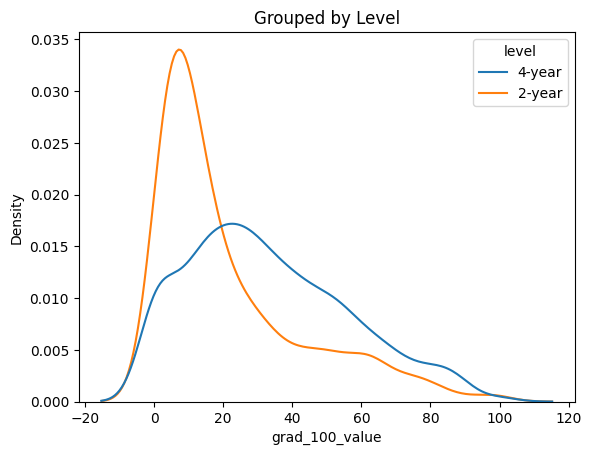

In [48]:
#Q2.5
conditioning1 = 'level'
var = 'grad_100_value'
sns.kdeplot( data=college_df, x=var, hue=conditioning, common_norm=False).set(title='Grouped by Level')

When grouped by level, the kernel density plot shows that both 4-year and 2-year institutions are skewed right. However, 2-year institutions have a much higher density than 4-year instutions when grad_100_value is between 0-20.

[Text(0.5, 1.0, 'Grouped by Control')]

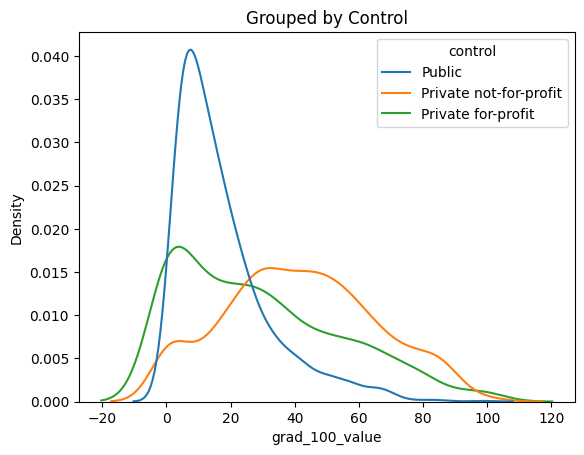

In [50]:
conditioning2 = 'control'
sns.kdeplot( data=college_df, x=var, hue=conditioning2, common_norm=False).set(title='Grouped by Control')

Public and private for-profit curves are both skewed right, while the private not-for-profit curve is mostly symmetrical. Like the 2-year curve from above, the public institution curve has a much higher density than the other curves when grad_100_value is between 0-20.

In [52]:
college_df.loc[:,['level','grad_100_value']].groupby('level').describe()

grad_100_value                                                      
                count       mean        std  min   25%   50%     75%    max
level                                                                      
2-year         1455.0  21.636151  21.645747  0.0   6.0  13.0  30.600  100.0
4-year         2012.0  33.230119  23.270160  0.0  15.2  29.7  49.225  100.0

In [53]:
college_df.loc[:,['control','grad_100_value']].groupby('control').describe()

grad_100_value                                          \
                                count       mean        std  min    25%   50%   
control                                                                         
Private for-profit              779.0  29.108858  25.601687  0.0   6.95  24.7   
Private not-for-profit         1189.0  41.660976  23.551231  0.0  25.00  41.0   
Public                         1499.0  17.430887  14.729443  0.0   6.90  13.2   

                                      
                          75%    max  
control                               
Private for-profit      46.75  100.0  
Private not-for-profit  58.30  100.0  
Public                  23.25   97.8

Based on the two plots, I would say that 4-year institutions have better graduation rates than 2-year institutions. I would also say that private not-for-profit institutions have the best graduation rates. This is also reflected in the descriptions above.  

Question 2.6

In [54]:
college_df['levelXcontrol']=college_df['level']+', '+college_df['control']

[Text(0.5, 1.0, 'Grouped by Level')]

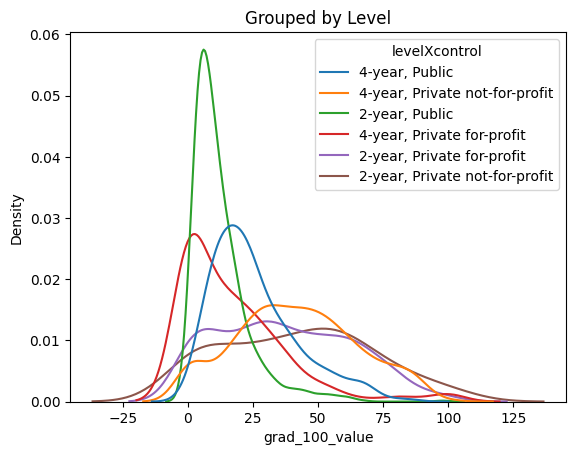

In [55]:
var = 'grad_100_value'
sns.kdeplot( data=college_df, x=var, hue=college_df['levelXcontrol'], common_norm=False).set(title='Grouped by Level')

Based on the plot, 2-year and 4-year private not-for-profit institutions appear to have the highest graduation rates.

Question 2.7

<Axes: ylabel='Density'>

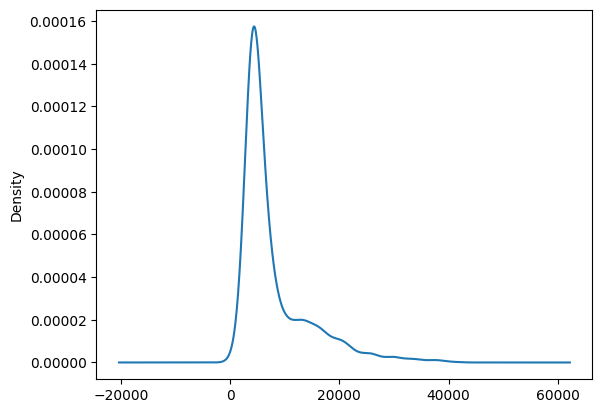

In [56]:
college_df['aid_value'].plot.density() #kernel density plot

[Text(0.5, 1.0, 'Grouped by Level')]

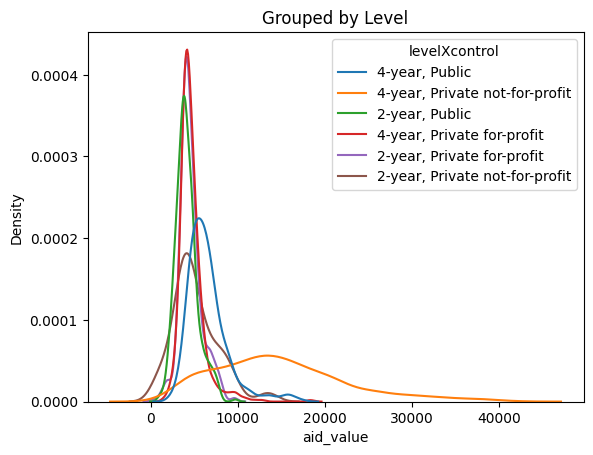

In [57]:
var = 'aid_value'
sns.kdeplot( data=college_df, x=var, hue=college_df['levelXcontrol'], common_norm=False).set(title='Grouped by Level')

In [58]:
college_df.loc[:,['levelXcontrol','aid_value']].groupby('levelXcontrol').describe()

aid_value                                     \
                                   count          mean          std     min   
levelXcontrol                                                                 
2-year, Private for-profit         464.0   4559.681034  1286.688269   294.0   
2-year, Private not-for-profit      68.0   5128.058824  2590.449946   934.0   
2-year, Public                     926.0   4126.199784  1260.271382   881.0   
4-year, Private for-profit         527.0   4696.062619  1489.410020  1580.0   
4-year, Private not-for-profit    1180.0  14702.401695  7649.775203   902.0   
4-year, Public                     632.0   6514.071203  2353.716693  2232.0   

                                                                     
                                    25%      50%       75%      max  
levelXcontrol                                                        
2-year, Private for-profit      3818.75   4286.5   5122.00   9727.0  
2-year, Private not-for-profit  3650.00   4516.5   6311.50  13654.0  
2-year, Public                  3311.25   3943.5   4762.00   9809.0  
4-year, Private for-profit      3885.50   4364.0   5131.50  18355.0  
4-year, Private not-for-profit  9113.25  13774.5  18996.75  41580.0  
4-year, Public                  4990.50   6085.0   7341.50  17299.0

The graph looks very condensed because only 4-year not-for-profit institutions has average aid values above 20000. These institutions also have the highest mean and count. 2-year public institutions have the lowest mean aid value.  

Question 2.8

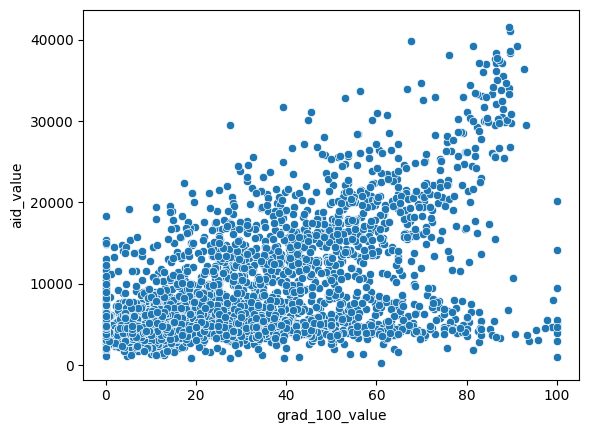

In [59]:
plot1 = sns.scatterplot(data = college_df, x='grad_100_value',y='aid_value')

Most points in the plot are concentrated in the lower left corner, indicating less aid and lower graduation rates. However, there does appear to be a slightly positive relationship between the two variables.

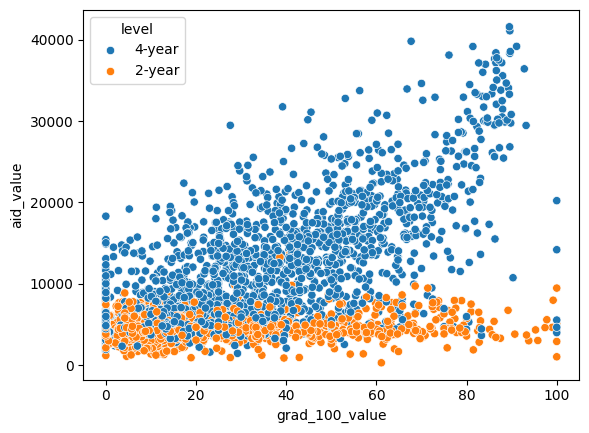

In [60]:
plot2 = sns.scatterplot(data = college_df, x='grad_100_value',y='aid_value', hue = 'level')

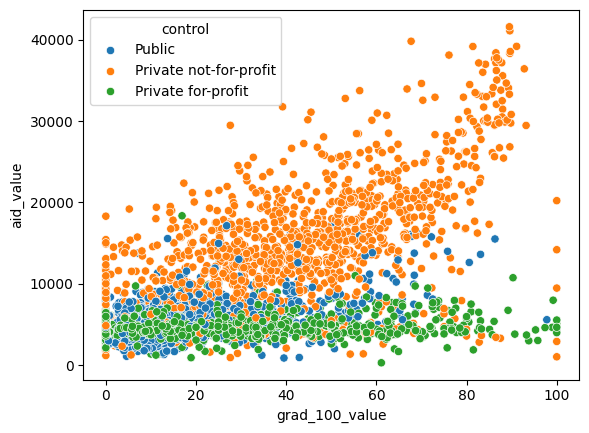

In [61]:
plot3 = sns.scatterplot(data = college_df, x='grad_100_value',y='aid_value', hue = 'control')

In the plot where the variables are grouped by level, it is clear that 2-year institutions do not give high amounts of aid. A vast majority of 2-year institutions give less than 10000 in aid. 4-year institutions seem to contribute to the positive relation I mentioned earlier. Graduation rates appear to increase as aid does for 4-year institutions.

In control-grouped plot, private-for-profit institutions have consistently low aid values. Although public institutions have higher values, neither group gives as much aid as private not-for-profit institutions. Private not-for-profit institutions seem to have higher graduation rates for higher aid values.